In [1]:
import json
import sys
from mrtparse import *
import networkx as nx
import matplotlib.pyplot as plt

import os
import requests
import gzip
import shutil
import openai

from neo4j import GraphDatabase

In [3]:
server_url = "https://data.ris.ripe.net"
rrc_name = "rrc00"
year = "2017"
month = "09"
date = "01"
time = "0800"

zip_file_name = "bview.{}{}{}.{}.gz".format(year,month,date,time)
filename = "bview.{}{}{}.{}".format(year,month,date,time)

remote_url = server_url + "/" + rrc_name + "/" + year + "." + month + "/" + zip_file_name
print(remote_url)

https://data.ris.ripe.net/rrc00/2017.09/bview.20170901.0800.gz


In [12]:
r = requests.get(remote_url, allow_redirects=True)

if(r.status_code==200):

    ## Removing the zip file if it exists
    if os.path.isfile(zip_file_name):
        os.remove(zip_file_name)

    ## Removing content file if it exists
    if os.path.isfile(filename):
        os.remove(filename)

    ## Obtaining the zip file
    with open(zip_file_name, 'wb') as f:
        f.write(r.content)

    ## Obtaining the content file
    with gzip.open(zip_file_name, 'rb') as f_in:
        with open(filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    ## Removing the zip file after extraction
    if os.path.isfile(zip_file_name):
        os.remove(zip_file_name)
else:
    print('File does not exist')

## Creating graph in networkx

In [4]:
#edge_connections = ""

G = nx.DiGraph()
node_check = []

i = 0
for entry in Reader(filename):

    curr_json = entry.data
    #check_json.append(curr_json)

    if list(curr_json['subtype'].values())[0]== "RIB_IPV4_UNICAST":

        if 'rib_entries' in curr_json.keys():

            entry_count = curr_json.get('entry_count',0)
            for j in range(entry_count):
                curr_list = curr_json['rib_entries'][j]['path_attributes'][1]['value'][0]['value']
                #check_list.append(curr_list)

                N = len(curr_list)
                for k in range(N-1):
                    if(curr_list[k+1]!=curr_list[k]): ## Avoiding same node cycles
                        G.add_edge(curr_list[k+1],curr_list[k])
                        node_check.append(curr_list[k+1])
                        node_check.append(curr_list[k])
        else:
            curr_list = curr_json['path_attributes'][1]['value'][0]['value']
            #check_list.append(curr_list)

            N = len(curr_list)
            for k in range(N-1):
                if(curr_list[k+1]!=curr_list[k]):
                    G.add_edge(curr_list[k+1],curr_list[k])
                    node_check.append(curr_list[k+1])
                    node_check.append(curr_list[k])


        i += 1

    if(i==20):
        break

#print(len(list(set(node_check))))

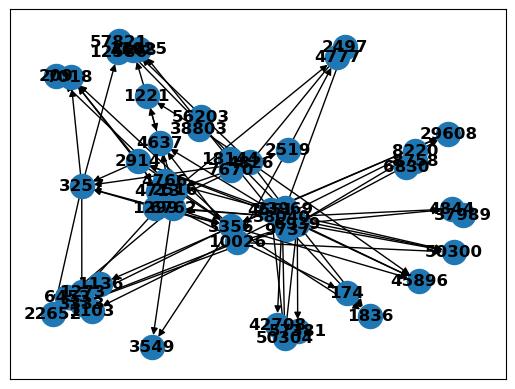

In [6]:
nx.draw_networkx(G, with_labels=True, font_weight='bold')

## Creating prompts from BGP data

In [5]:
formatted_string = ""
connect_list = []

i = 0
for entry in Reader(filename):

    curr_json = entry.data
    #check_json.append(curr_json)

    if list(curr_json['subtype'].values())[0]== "RIB_IPV4_UNICAST":

        if 'rib_entries' in curr_json.keys():

            entry_count = curr_json.get('entry_count',0)
            for j in range(entry_count):
                curr_list = curr_json['rib_entries'][j]['path_attributes'][1]['value'][0]['value']
                #check_list.append(curr_list)

                N = len(curr_list)
                for k in range(N-1):
                    if(curr_list[k+1]!=curr_list[k]): ## Avoiding same node cycles
                        connect_list.append(curr_list[k+1] + " CONNECTS " + curr_list[k])
                        #connect_list.append(curr_list[k+1] + " is connected to " + curr_list[k])
        else:
            curr_list = curr_json['path_attributes'][1]['value'][0]['value']
            #check_list.append(curr_list)

            N = len(curr_list)
            for k in range(N-1):
                if(curr_list[k+1]!=curr_list[k]):
                    connect_list.append(curr_list[k+1] + " CONNECTS " + curr_list[k])
                    #connect_list.append(curr_list[k+1] + " is connected to " + curr_list[k])


        i += 1

    if(i==20):
        break

connect_list = list(set(connect_list))
formatted_string = "\n".join(connect_list)
#print(formatted_string)

In [ ]:
# ## Removing content file after reading
# if os.path.isfile(filename):
#     os.remove(filename)

## ChatGPT setup

In [7]:
import os
name = 'OPENAI_API_KEY'

key_location = "/Users/kiranjyothisheena/Documents/Kiran_Files/Capstone/OpenAPI_Key"
key_file = open(key_location, "r")
openapi_key = key_file.readline()

#secret = getpass.getpass("Enter the OpenAI API Key")
os.environ[name] = openapi_key
print(f"Have successfully set up {name} as an environment variable.")

Have successfully set up OPENAI_API_KEY as an environment variable.


In [14]:
# Define your API key (keep it secret!)
openai.api_key = openapi_key
API_KEY = openapi_key

In [9]:
system_prompt = """
You are an assistant that helps to generate text to form nice and human understandable answers based.
The latest prompt contains the information, and you need to generate a human readable response based on the given information.
Make the answer sound as a response to the question. Do not mention that you based the result on the given information.
Do not add any additional information that is not explicitly provided in the latest prompt.
I repeat, do not add any information that is not explicitly given.
"""
# context = 'A is connected to D with a cost of 100, A is connected to C with a cost of 50, A is connected to B with a cost of 50, B is connected to D with a cost of 40, C is connected to E with a cost of 80, C is connected to D with a cost of 40, D is connected to A with a cost of 69, D is connected to F with a cost of 80, D is connected to E with a cost of 30, E is connected to F with a cost of 40'
context = """
In a graph structure, we define the arc relation as CONNECTS.
So as an example, A CONNECTS B implies node A and node B exists and there exists an arc
which connects A to B. The following are statements which defines the current graph.
From each case, add both the nodes to the node list if it does not already exists and define the arcs based on the
earlier statement

""" + formatted_string

#context =  formatted_string


def generate_user_prompt(question, context):
    return f"""
       The question is {question}
       Answer the question by using the provided information:
       {context}
       """

In [10]:
import openai

def get_gpt3_response(system_prompt, prompt, context, api_key, model="gpt-3.5-turbo"):
    """
    Send a request to the OpenAI Chat API and get a response from the model.
    
    Args:
        prompt (str): The user's question.
        context (str): Contextual information to be passed to the model.
        api_key (str): Your OpenAI API key.
        model (str): The model version to use, default is "gpt-3.5-turbo".
    
    Returns:
        str: The model's response.
    """
    
    # Create the full prompt by combining the system prompt, context, and the user question
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": generate_user_prompt(prompt, context)}
    ]
    
    # Use the OpenAI Python client to send the request
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages
    )
    
    # Extract the response text and return
    return response.choices[0].message['content']

# Tests

In [12]:
# Example usage
question = "How many nodes does the graph have?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

Based on the provided information, the graph has a total of 42 unique nodes.


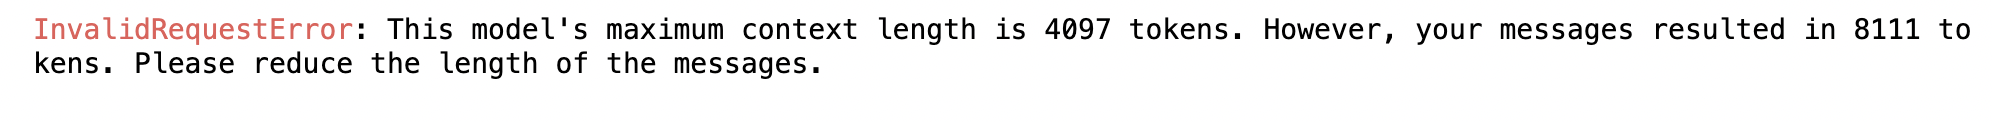

We got the above error when we used 20 messages without deduplicating

In [13]:
print(G.number_of_nodes())

50


In [14]:
# Extremely volatile answer
question = "How many edges does the graph have"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

Based on the provided information, we can determine the number of edges in the graph by counting the number of connections. In total, there are 88 connections mentioned in the information. Therefore, the graph has 88 edges.


In [15]:
print(G.number_of_edges())

100


In [16]:
# Extremely volatile answer
question = "What is the in degree of node 29608"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

The in degree of node 29608 is 3.


In [17]:
print(G.in_degree('29608'))

3


In [96]:
# Extremely volatile answer
question = "What is the in degree of node 2519"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

The in degree of node 2519 is 2.


In [98]:
# Extremely volatile answer
question = "What is the in degree of node 2519?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

The in degree of node 2519 is 2. Node 2519 connects to nodes 7670 and 10026.


In [94]:
# Extremely volatile answer
question = "What is the out degree of node 2519"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

The out degree of node 2519 is 2. Node 2519 only connects to nodes 4777 and 10026.


In [95]:
print(G.in_degree('2519'),G.out_degree('2519'))

1 2


## Checking if adjacency is better

In [7]:
adj_sparse = nx.adjacency_matrix(G)
adj_full = adj_sparse.todense()
node_list = list(G.nodes())
#print(adj_sparse)

/var/folders/hn/4swgrrzj36vd9rq1mqmr39j80000gn/T/ipykernel_2027/674613905.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_sparse = nx.adjacency_matrix(G)


In [9]:
## Mapping the values to 
nonzero_indices = adj_sparse.nonzero()
nonzero_values = adj_sparse.data
mapping_string = ""
adj_string = ""

for j in range(len(node_list)):
    mapping_string = mapping_string + str(j) + ":" + node_list[j] + "\n"

for j in range(len(nonzero_values)):
    adj_string = adj_string + "(" + str(nonzero_indices[0][j]) + "," + str(nonzero_indices[1][j]) + ")\n"

#print(adj_string)

In [27]:
system_prompt = """
You are an assistant that helps to generate text to form nice and human understandable answers based.
The latest prompt contains the information, and you need to generate a human readable response based on the given information.
Make the answer sound as a response to the question. Do not mention that you based the result on the given information.
Do not add any additional information that is not explicitly provided in the latest prompt.
I repeat, do not add any information that is not explicitly given.
"""
# context = 'A is connected to D with a cost of 100, A is connected to C with a cost of 50, A is connected to B with a cost of 50, B is connected to D with a cost of 40, C is connected to E with a cost of 80, C is connected to D with a cost of 40, D is connected to A with a cost of 69, D is connected to F with a cost of 80, D is connected to E with a cost of 30, E is connected to F with a cost of 40'
context = """
For a simple graph with vertex set U = {u1, …, un}, the adjacency matrix is a square n × n matrix A 
such that its element Aij is one when there is an edge from vertex ui to vertex uj, 
and zero when there is no edge.

The following string represents the sparse representation of the adjacency matrix  of a directional graph,
where each element represents a connected arc. For example (0,1) shows that there is an arc directed from node 0
to node 1.This is just an example and should not be added in the data.
Please do not forget these relations and store it as it is.

""" + adj_string 

context = context + """
 To make sure you remember the relations properly I am adding the adj_string again
 
""" + adj_string

context =  context + """

Each element index is represented by a node name as given as follows, For example 0:ABC shows that in the above
sparse representation, index 0 is represented by the node ABC. This is just an example and should not be added in the data.
The representation is as follows, 

""" + mapping_string

context = context + """
Please provide insights or calculations based on the graph of the above sparse matrix.
"""

def generate_user_prompt(question, context):
    return f"""
       The question is {question}
       Answer the question by using the provided information:
       {context}
      """

In [28]:
import openai

def get_gpt3_response(system_prompt, prompt, context, api_key, model="gpt-3.5-turbo"):
    """
    Send a request to the OpenAI Chat API and get a response from the model.
    
    Args:
        prompt (str): The user's question.
        context (str): Contextual information to be passed to the model.
        api_key (str): Your OpenAI API key.
        model (str): The model version to use, default is "gpt-3.5-turbo".
    
    Returns:
        str: The model's response.
    """
    
    # Create the full prompt by combining the system prompt, context, and the user question
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": generate_user_prompt(prompt, context)}
    ]
    
    # Use the OpenAI Python client to send the request
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages
    )
    
    # Extract the response text and return
    return response.choices[0].message['content']

In [29]:
# Example usage
question = "How many nodes does the graph have?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

Based on the given sparse representation of the adjacency matrix, we can analyze the graph to determine the number of nodes it has. Each element in the representation corresponds to a node in the graph.

From the given representation, we can see that there are 50 elements or nodes represented, which means the graph has a total of 50 nodes.


In [16]:
# Example usage
question = "How many edges does the graph have?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

To determine the number of edges in the graph represented by the given sparse matrix, we need to count the number of connected arcs or elements in the sparse representation.
From the provided sparse representation of the adjacency matrix, we can observe that each line represents a connected arc between two nodes. 

Counting all the arcs in the sparse representation, we find that there are a total of 81 connected arcs. Therefore, the graph has 81 edges.


In [56]:
print(G.number_of_edges())

100


In [30]:
# Extremely volatile answer
question = "What is the in degree of node 29608"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

To determine the in degree of a node in a graph represented by the given sparse matrix, we need to count the number of arcs directed towards that node.

From the given sparse matrix, we can see that the node 29608 is represented by index 18. To determine the in degree of this node, we need to find all the arcs in the sparse matrix that have 29608 as their destination.

After examining the sparse matrix, we can see that the following arcs have 29608 as their destination:
(2,18)
(44,18)

Therefore, the in degree of node 29608 is 2, as there are two arcs directed towards it.


In [31]:
print(G.in_degree('29608'))

3


In [33]:
# Extremely volatile answer
question = "What is the shortest path from node 6939 to 29608?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

To find the shortest path from node 6939 to 29608, we can analyze the sparse representation of the adjacency matrix. Let's first represent the nodes by their corresponding indices:

6939: 6
29608: 18

Looking at the sparse representation, we can see that there are direct arcs from node 6 to nodes 1, 3, 5, 12, 15, 18, 19, 20, 21, and 24. However, there is no direct arc from node 6 to node 18. We need to find an alternative path.

From node 6, there is a direct arc to node 20, and from node 20, there is a direct arc to node 18. Therefore, the shortest path from node 6 to node 18 is through nodes 6, 20, and 18.

In summary, the shortest path from node 6939 to 29608 is: 6939 -> 20 -> 29608.


In [32]:
print(nx.shortest_path(G, source='6939', target='29608'))

['6939', '29608']


# Smaller graph

In [7]:
#edge_connections = ""

G = nx.DiGraph()
node_check = []

i = 0
for entry in Reader(filename):

    curr_json = entry.data
    #check_json.append(curr_json)

    if list(curr_json['subtype'].values())[0]== "RIB_IPV4_UNICAST":

        if 'rib_entries' in curr_json.keys():

            entry_count = curr_json.get('entry_count',0)
            for j in range(entry_count):
                curr_list = curr_json['rib_entries'][j]['path_attributes'][1]['value'][0]['value']
                #check_list.append(curr_list)

                N = len(curr_list)
                for k in range(N-1):
                    if(curr_list[k+1]!=curr_list[k]): ## Avoiding same node cycles
                        G.add_edge(curr_list[k+1],curr_list[k])
                        node_check.append(curr_list[k+1])
                        node_check.append(curr_list[k])
        else:
            curr_list = curr_json['path_attributes'][1]['value'][0]['value']
            #check_list.append(curr_list)

            N = len(curr_list)
            for k in range(N-1):
                if(curr_list[k+1]!=curr_list[k]):
                    G.add_edge(curr_list[k+1],curr_list[k])
                    node_check.append(curr_list[k+1])
                    node_check.append(curr_list[k])


        i += 1

    if(i==5):
        break

#print(len(list(set(node_check))))

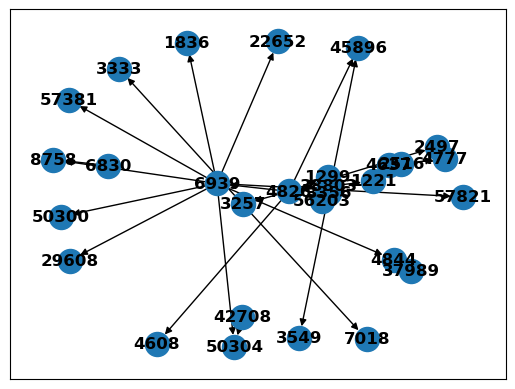

In [8]:
nx.draw_networkx(G, with_labels=True, font_weight='bold')

## Creating prompts from BGP data

In [10]:
formatted_string = ""
connect_list = []

i = 0
for entry in Reader(filename):

    curr_json = entry.data
    #check_json.append(curr_json)

    if list(curr_json['subtype'].values())[0]== "RIB_IPV4_UNICAST":

        if 'rib_entries' in curr_json.keys():

            entry_count = curr_json.get('entry_count',0)
            for j in range(entry_count):
                curr_list = curr_json['rib_entries'][j]['path_attributes'][1]['value'][0]['value']
                #check_list.append(curr_list)

                N = len(curr_list)
                for k in range(N-1):
                    if(curr_list[k+1]!=curr_list[k]): ## Avoiding same node cycles
                        #connect_list.append(curr_list[k+1] + " CONNECTS " + curr_list[k])
                        connect_list.append(curr_list[k+1] + " is connected to " + curr_list[k] + " by a directed arc")
        else:
            curr_list = curr_json['path_attributes'][1]['value'][0]['value']
            #check_list.append(curr_list)

            N = len(curr_list)
            for k in range(N-1):
                if(curr_list[k+1]!=curr_list[k]):
                    #connect_list.append(curr_list[k+1] + " CONNECTS " + curr_list[k])
                    connect_list.append(curr_list[k+1] + " is connected to " + curr_list[k]+ " by a directed arc")


        i += 1

    if(i==5):
        break

connect_list = list(set(connect_list))
formatted_string = "\n".join(connect_list)
#print(formatted_string)

In [ ]:
# ## Removing content file after reading
# if os.path.isfile(filename):
#     os.remove(filename)

In [11]:
import os
name = 'OPENAI_API_KEY'

key_location = "/Users/kiranjyothisheena/Documents/Kiran_Files/Capstone/OpenAPI_Key"
key_file = open(key_location, "r")
openapi_key = key_file.readline()

#secret = getpass.getpass("Enter the OpenAI API Key")
os.environ[name] = openapi_key
print(f"Have successfully set up {name} as an environment variable.")

Have successfully set up OPENAI_API_KEY as an environment variable.


In [14]:
# Define your API key (keep it secret!)
openai.api_key = openapi_key
API_KEY = openapi_key

In [43]:
system_prompt = """
You are an assistant that helps to generate text to form nice and human understandable answers based.
The latest prompt contains the information, and you need to generate a human readable response based on the given information.
Make the answer sound as a response to the question. Do not mention that you based the result on the given information.
Do not add any additional information that is not explicitly provided in the latest prompt.
I repeat, do not add any information that is not explicitly given.
"""
# context = 'A is connected to D with a cost of 100, A is connected to C with a cost of 50, A is connected to B with a cost of 50, B is connected to D with a cost of 40, C is connected to E with a cost of 80, C is connected to D with a cost of 40, D is connected to A with a cost of 69, D is connected to F with a cost of 80, D is connected to E with a cost of 30, E is connected to F with a cost of 40'
context = """
In a graph structure, we define the arc relation between each node as follows 

""" + formatted_string


def generate_user_prompt(question, context):
    return f"""
       The question is {question}
       Answer the question by using the provided information:
       {context}
       """

In [45]:
import openai

def get_gpt3_response(system_prompt, prompt, context, api_key, model="gpt-3.5-turbo"):
    """
    Send a request to the OpenAI Chat API and get a response from the model.
    
    Args:
        prompt (str): The user's question.
        context (str): Contextual information to be passed to the model.
        api_key (str): Your OpenAI API key.
        model (str): The model version to use, default is "gpt-3.5-turbo".
    
    Returns:
        str: The model's response.
    """
    
    # Create the full prompt by combining the system prompt, context, and the user question
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": generate_user_prompt(prompt, context)}
    ]
    
    # Use the OpenAI Python client to send the request
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages
    )
    
    # Extract the response text and return
    return response.choices[0].message['content']

In [54]:
# Example usage
question = "How many nodes does the graph have? What are they?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

The graph has a total of 29 nodes. The nodes in the graph are 4826, 1299, 6939, 1836, 56203, 38803, 45896, 3257, 7018, 50300, 6830, 8758, 4844, 29608, 50304, 57821, 3356, 3549, 4637, 2516, 22652, 42708, 4777, 1221, 2497, 3333, 4608, 57381, and 37989.


In [51]:
print(G.number_of_nodes())

29


In [48]:
# Extremely volatile answer
question = "How many edges does the graph have"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

Based on the given information, the graph has 33 edges. Each line represents a directed arc connecting two nodes in the graph. By counting the number of directed arcs mentioned, we can determine the number of edges in the graph. In this case, there are 33 directed arcs mentioned, so the graph has 33 edges.


In [49]:
print(G.number_of_edges())

30


In [37]:
# Extremely volatile answer
question = "What is the in degree of node 29608"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

The in-degree of node 29608 is 1. This means that there is only one directed arc that connects to node 29608. Specifically, node 6939 is connected to node 29608 by a directed arc.


In [39]:
print(G.in_degree('29608'))

1


In [40]:
# Extremely volatile answer
question = "What is the in degree of node 2519"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

The in degree of node 2519 is not provided in the given information.


In [41]:
# Extremely volatile answer
question = "What is the out degree of node 2519"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

To find the out-degree of node 2519, we need to go through the list of arcs and count how many arcs are directed away from node 2519. However, node 2519 is not mentioned in the given information, so we cannot determine its out-degree without any additional information. We need to know the arcs involving node 2519 in order to calculate its out-degree.


In [42]:
print(G.in_degree('2519'),G.out_degree('2519'))

[] []


## Smaller graph - Adjacency approach

In [55]:
adj_sparse = nx.adjacency_matrix(G)
adj_full = adj_sparse.todense()
node_list = list(G.nodes())
#print(adj_sparse)

/var/folders/hn/4swgrrzj36vd9rq1mqmr39j80000gn/T/ipykernel_2027/674613905.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_sparse = nx.adjacency_matrix(G)


In [56]:
## Mapping the values to 
nonzero_indices = adj_sparse.nonzero()
nonzero_values = adj_sparse.data
mapping_string = ""
adj_string = ""

for j in range(len(node_list)):
    mapping_string = mapping_string + str(j) + ":" + node_list[j] + "\n"

for j in range(len(nonzero_values)):
    adj_string = adj_string + "(" + str(nonzero_indices[0][j]) + "," + str(nonzero_indices[1][j]) + ")\n"

#print(adj_string)

In [57]:
system_prompt = """
You are an assistant that helps to generate text to form nice and human understandable answers based.
The latest prompt contains the information, and you need to generate a human readable response based on the given information.
Make the answer sound as a response to the question. Do not mention that you based the result on the given information.
Do not add any additional information that is not explicitly provided in the latest prompt.
I repeat, do not add any information that is not explicitly given.
"""
# context = 'A is connected to D with a cost of 100, A is connected to C with a cost of 50, A is connected to B with a cost of 50, B is connected to D with a cost of 40, C is connected to E with a cost of 80, C is connected to D with a cost of 40, D is connected to A with a cost of 69, D is connected to F with a cost of 80, D is connected to E with a cost of 30, E is connected to F with a cost of 40'
context = """
For a simple graph with vertex set U = {u1, …, un}, the adjacency matrix is a square n × n matrix A 
such that its element Aij is one when there is an edge from vertex ui to vertex uj, 
and zero when there is no edge.

The following string represents the sparse representation of the adjacency matrix  of a directional graph,
where each element represents a connected arc. For example (0,1) shows that there is an arc directed from node 0
to node 1.This is just an example and should not be added in the data.
Please do not forget these relations and store it as it is.

""" + adj_string 

context = context + """
 To make sure you remember the relations properly I am adding the adj_string again
 
""" + adj_string

context =  context + """

Each element index is represented by a node name as given as follows, For example 0:ABC shows that in the above
sparse representation, index 0 is represented by the node ABC. This is just an example and should not be added in the data.
The representation is as follows, 

""" + mapping_string

context = context + """
Please provide insights or calculations based on the graph of the above sparse matrix.
"""

def generate_user_prompt(question, context):
    return f"""
       The question is {question}
       Answer the question by using the provided information:
       {context}
      """

In [58]:
import openai

def get_gpt3_response(system_prompt, prompt, context, api_key, model="gpt-3.5-turbo"):
    """
    Send a request to the OpenAI Chat API and get a response from the model.
    
    Args:
        prompt (str): The user's question.
        context (str): Contextual information to be passed to the model.
        api_key (str): Your OpenAI API key.
        model (str): The model version to use, default is "gpt-3.5-turbo".
    
    Returns:
        str: The model's response.
    """
    
    # Create the full prompt by combining the system prompt, context, and the user question
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": generate_user_prompt(prompt, context)}
    ]
    
    # Use the OpenAI Python client to send the request
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages
    )
    
    # Extract the response text and return
    return response.choices[0].message['content']

In [59]:
# Example usage
question = "How many nodes does the graph have?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

Based on the given sparse representation of the adjacency matrix of a directional graph, we can observe that there are 29 nodes in the graph. Each node is represented by an index and a corresponding name, as shown in the representation provided.

To determine the number of nodes in the graph, we can count the number of distinct node indices mentioned in the sparse representation. In this case, there are 29 distinct node indices, indicating that the graph has 29 nodes.


In [60]:
# Example usage
question = "How many edges does the graph have?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

To calculate the number of edges in the graph based on the given sparse representation of the adjacency matrix, we need to count the number of elements in the sparse representation.

From the provided data, we can see that there are 30 elements in the sparse representation. Each element represents a connected arc or edge in the graph. Therefore, the graph has a total of 30 edges.


In [63]:
print(G.number_of_edges(),G.number_of_nodes())

30 29


In [64]:
# Extremely volatile answer
question = "What is the in degree of node 29608"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

Based on the provided sparse representation of the adjacency matrix, we can determine the in-degree of node 29608.
The node 29608 is represented by the index 18 in the representation, and in-degree is the number of incoming edges to a node.

By observing the sparse representation, we can see that there is an arc or edge directed towards node 29608 from node 18.
Therefore, the in-degree of node 29608 in this graph is 1.


In [65]:
print(G.in_degree('29608'))

1


In [33]:
# Extremely volatile answer
question = "What is the shortest path from node 6939 to 29608?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

To find the shortest path from node 6939 to 29608, we can analyze the sparse representation of the adjacency matrix. Let's first represent the nodes by their corresponding indices:

6939: 6
29608: 18

Looking at the sparse representation, we can see that there are direct arcs from node 6 to nodes 1, 3, 5, 12, 15, 18, 19, 20, 21, and 24. However, there is no direct arc from node 6 to node 18. We need to find an alternative path.

From node 6, there is a direct arc to node 20, and from node 20, there is a direct arc to node 18. Therefore, the shortest path from node 6 to node 18 is through nodes 6, 20, and 18.

In summary, the shortest path from node 6939 to 29608 is: 6939 -> 20 -> 29608.
